In [1]:
import os
import gzip
import scipy
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=300, dpi_save=500)
from matplotlib import rcParams
rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 500

In [2]:
data_dir = '../../../Data/Spatial/Transcriptomics/VisiumHD_CRC_Oliveira2024/'
if not os.path.exists(data_dir + 'processed/'):
    os.makedirs(data_dir + 'processed/')

### Visium HD data

In [3]:
slice_name_list = ['P1CRC', 'P2CRC', 'P5CRC']
adata_list = []
adata_list_2 = []

for slice_name in slice_name_list:

    meta = pd.read_parquet(data_dir+f'raw/{slice_name}/binned_outputs/square_008um/{slice_name}_Metadata.parquet')
    meta = meta.set_index('barcode')
    meta.index.name = None

    adata = sc.read_10x_h5(data_dir+f'raw/{slice_name}/binned_outputs/square_008um/filtered_feature_bc_matrix.h5')

    new_obs = adata.obs.join(meta, how='left')
    new_obs.index.name = None
    adata.obs = new_obs

    adata.obsm['spatial'] = adata.obs[['X', 'Y']].to_numpy()
    adata.var_names_make_unique()
    adata2 = adata[adata.obs['DeconvolutionClass']=='singlet', :].copy()
    print(adata)
    print(adata2)

    # adata.write_h5ad(data_dir+f'processed/{slice_name}.h5ad')
    # adata2.write_h5ad(data_dir+f'processed/{slice_name}_singlet.h5ad')

    adata_list.append(adata)
    adata_list_2.append(adata2)

AnnData object with n_obs × n_vars = 507684 × 18085
    obs: 'tissue', 'X', 'Y', 'DeconvolutionClass', 'DeconvolutionLabel1', 'DeconvolutionLabel2', 'Periphery', 'UnsupervisedL1', 'UnsupervisedL2', 'MacrophageSubtype', 'GobletSubcluster'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 235530 × 18085
    obs: 'tissue', 'X', 'Y', 'DeconvolutionClass', 'DeconvolutionLabel1', 'DeconvolutionLabel2', 'Periphery', 'UnsupervisedL1', 'UnsupervisedL2', 'MacrophageSubtype', 'GobletSubcluster'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 545913 × 18085
    obs: 'tissue', 'X', 'Y', 'DeconvolutionClass', 'DeconvolutionLabel1', 'DeconvolutionLabel2', 'Periphery', 'UnsupervisedL1', 'UnsupervisedL2', 'MacrophageSubtype', 'GobletSubcluster'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 322327 × 18085
    obs: 'tissue', 'X', 'Y', 'Dec

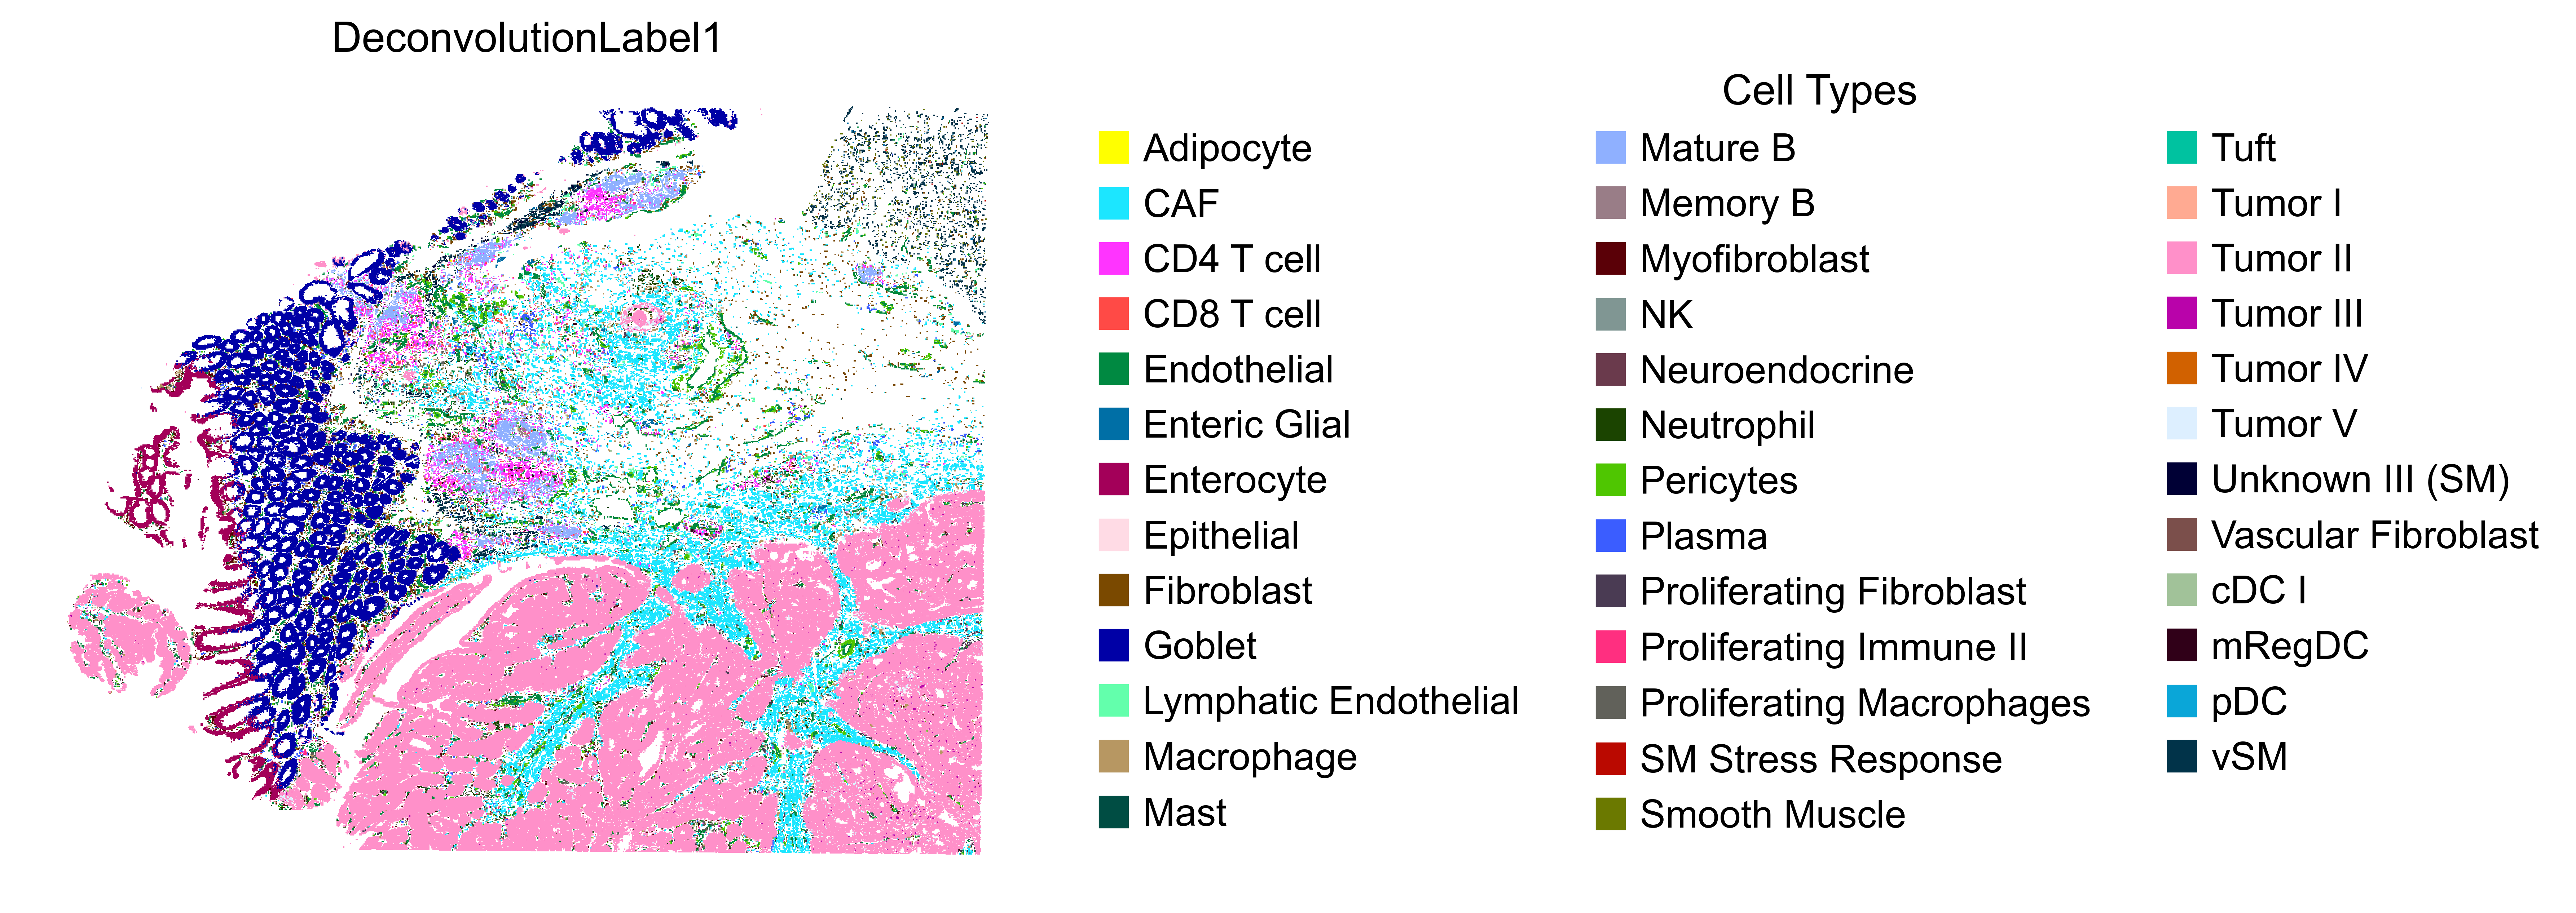

In [4]:
colors = ['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6', '#a30059', '#ffdbe5', '#7a4900', '#0000a6', 
          '#63ffac', '#b79762', '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c', '#1b4400', '#4fc601', 
          '#3b5dff', '#4a3b53', '#ff2f80', '#61615a', '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa', 
          '#d16100', '#ddefff', '#000035', '#7b4f4b', '#a1c299', '#300018', '#0aa6d8', '#013349']
celltypes = ['Adipocyte', 'CAF', 'CD4 T cell', 'CD8 T cell', 'Endothelial', 'Enteric Glial', 'Enterocyte', 'Epithelial',
             'Fibroblast', 'Goblet', 'Lymphatic Endothelial', 'Macrophage', 'Mast', 'Mature B', 'Memory B', 'Myofibroblast',
             'NK', 'Neuroendocrine', 'Neutrophil', 'Pericytes', 'Plasma', 'Proliferating Fibroblast', 'Proliferating Immune II',
             'Proliferating Macrophages', 'SM Stress Response', 'Smooth Muscle', 'Tuft', 'Tumor I', 'Tumor II', 'Tumor III',
             'Tumor IV', 'Tumor V', 'Unknown III (SM)', 'Vascular Fibroblast', 'cDC I', 'mRegDC', 'pDC', 'vSM']
color_dict = {ct: color for ct, color in zip(celltypes, colors)}

fig, ax = plt.subplots(figsize=(6, 5))

sc.pl.embedding(adata_list_2[0], basis='spatial', palette=color_dict, 
                color='DeconvolutionLabel1', ax=ax, frameon=False, marker='s', size=0.2, show=False)

handles = [
    mpatches.Patch(color=color, label=ct)
    for ct, color in zip(celltypes, colors)
]

ax.legend(handles=handles, title='Cell Types', loc=(1.05, 0.05), frameon=False, handleheight=0.8, handlelength=0.7, ncol=3)
plt.show()

### Xenium data

In [3]:
slice_name_list = ['P1CRC', 'P2CRC', 'P5CRC']
adata_list_Xenium = []

for slice_name in slice_name_list:

    meta = pd.read_parquet(data_dir+f'raw/{slice_name}/Xenium/cells.parquet')
    meta = meta.set_index('cell_id')
    meta.index.name = None

    adata = sc.read_10x_h5(data_dir+f'raw/{slice_name}/Xenium/cell_feature_matrix.h5')

    new_obs = adata.obs.join(meta, how='left')
    new_obs.index.name = None
    adata.obs = new_obs

    adata.obsm['spatial'] = -adata.obs[['y_centroid', 'x_centroid']].to_numpy()
    print(adata)

    # adata.write_h5ad(data_dir+f'processed/{slice_name}_Xenium.h5ad')

    adata_list_Xenium.append(adata)

AnnData object with n_obs × n_vars = 307762 × 422
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 340837 × 422
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 275998 × 422
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'


In [4]:
for i in range(len(slice_name_list)):
    sc.pp.normalize_total(adata_list_Xenium[i], target_sum=1e4)
    sc.pp.log1p(adata_list_Xenium[i])

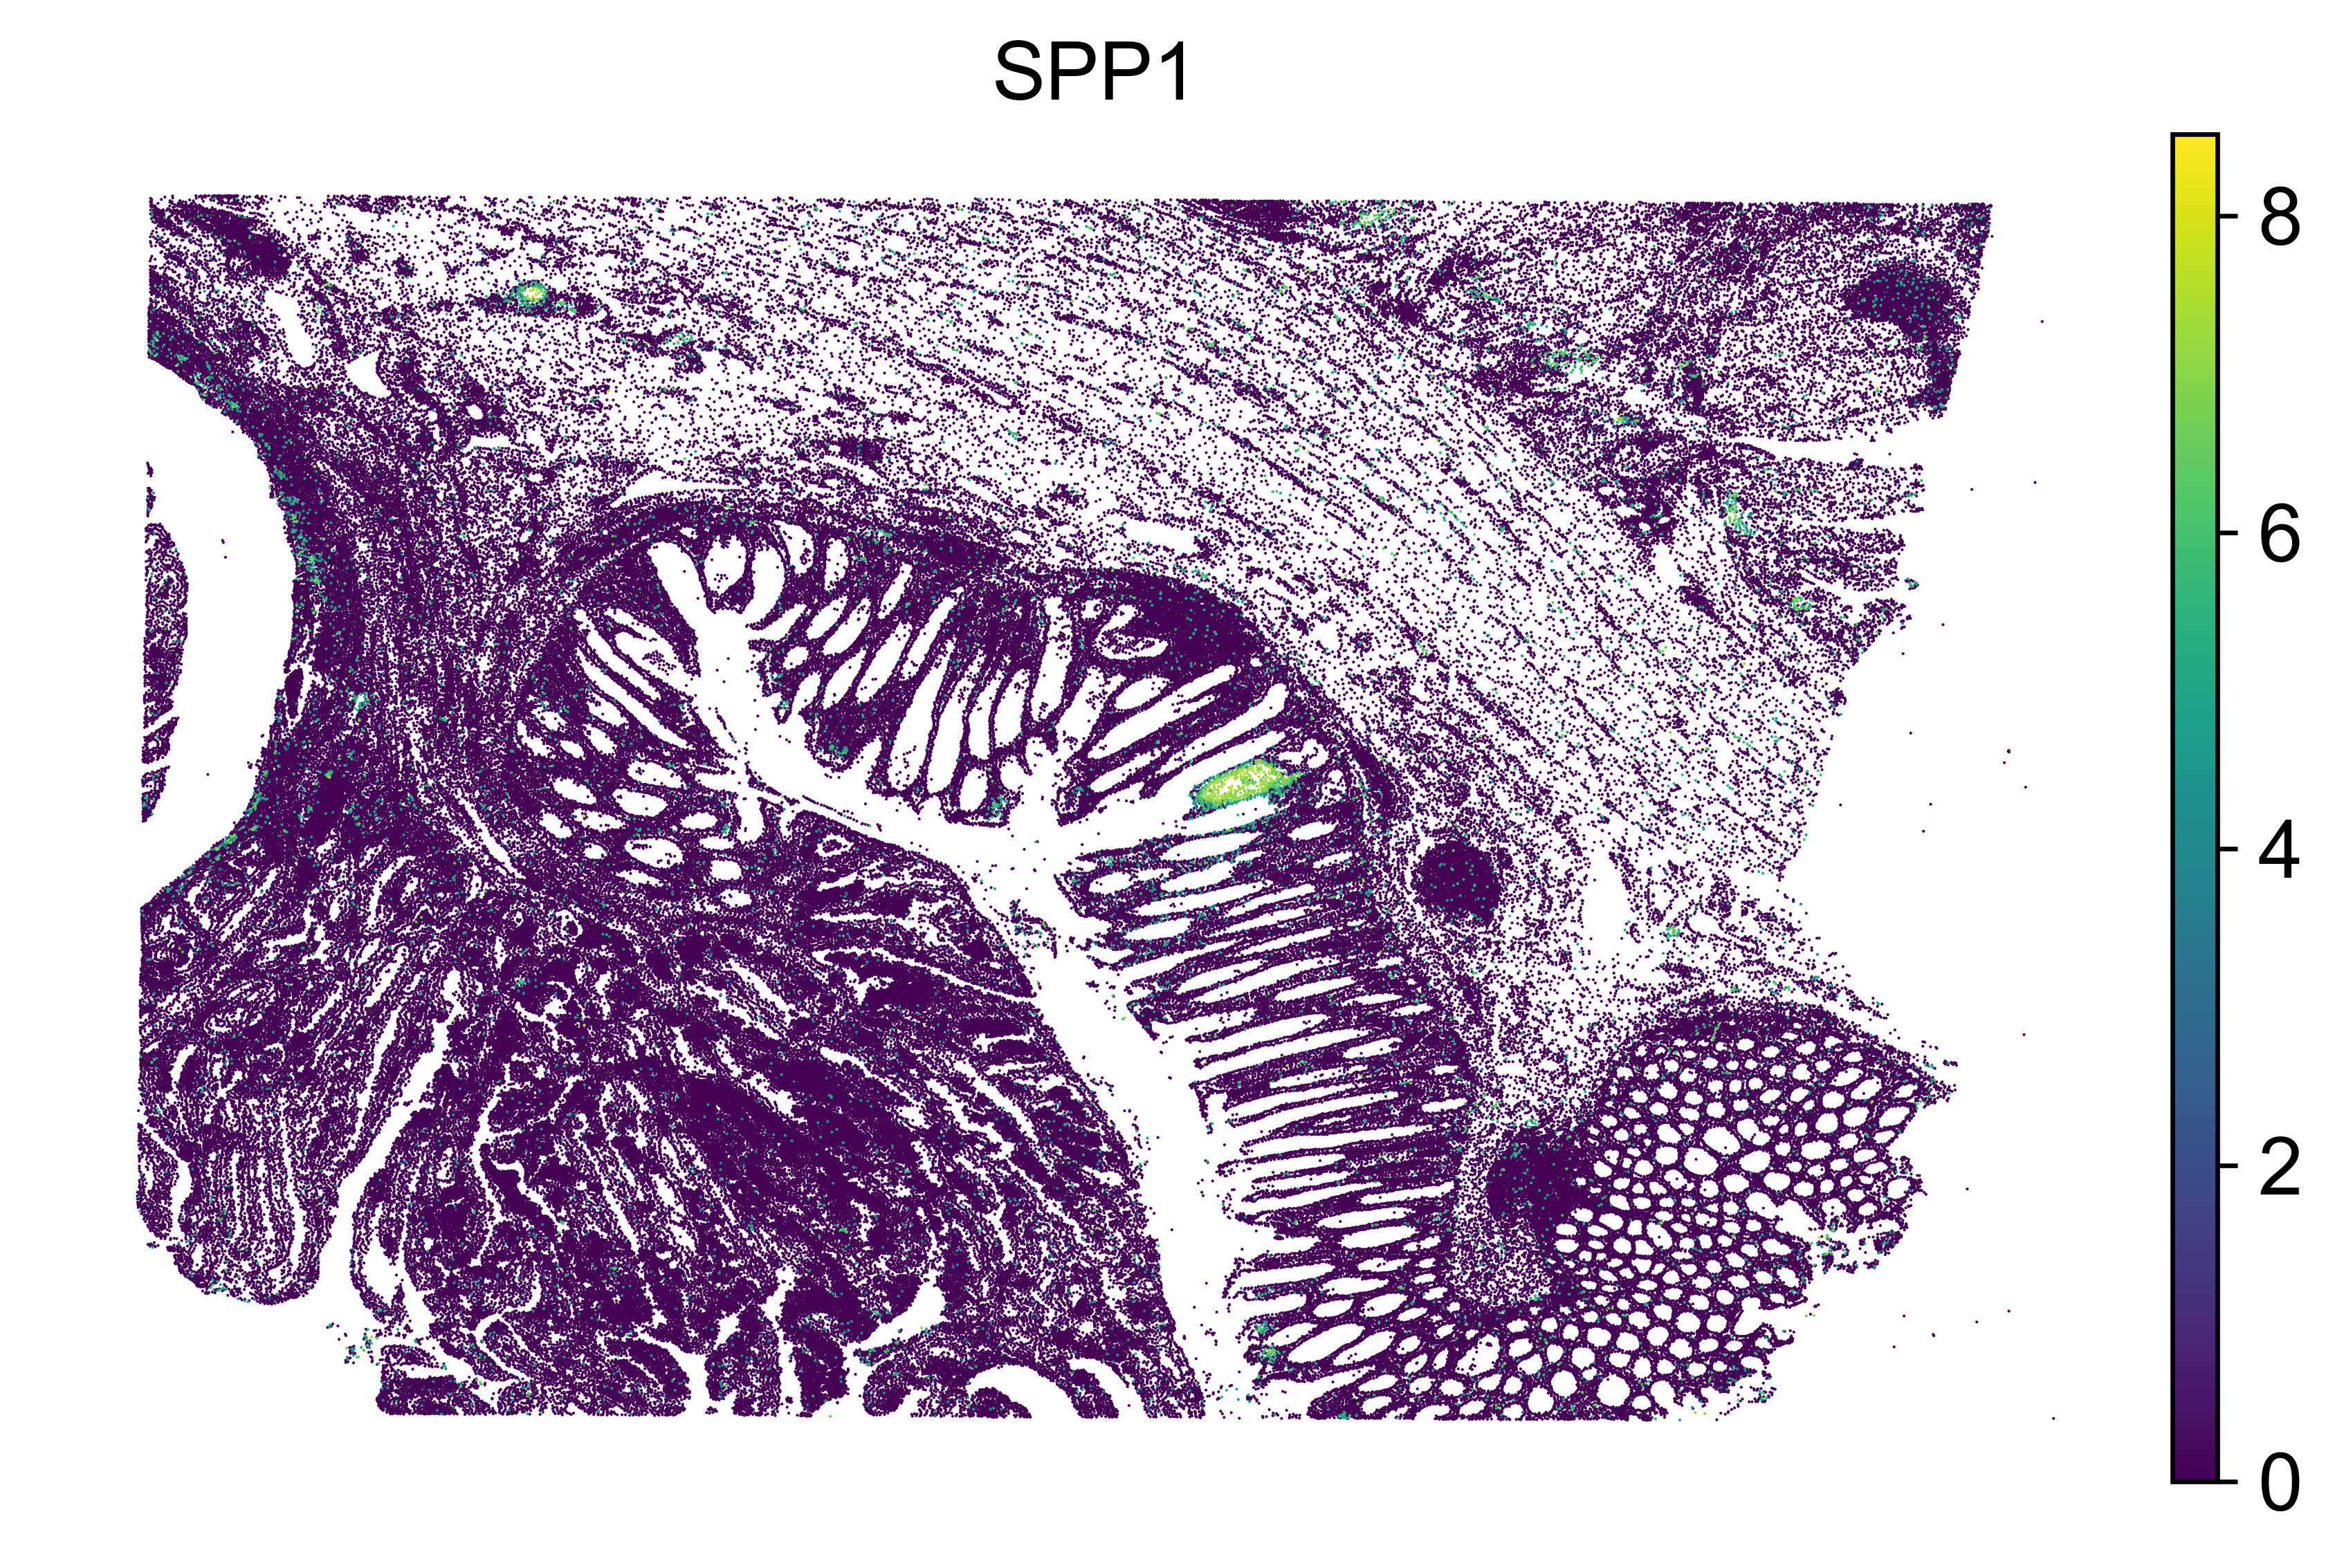

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sc.pl.embedding(adata_list_Xenium[2], basis='spatial', palette='viridis',
                color='SPP1', ax=ax, frameon=False, size=1, show=False)

plt.tight_layout()
plt.show()